# Business Problem

Customer churn occurs when customers cease doing business with a firm. Retaining existing customers is more cost efficient than trying to attract new customers. With intense competition in the telecommunications industry, it would thus be advantageous for a firm to be able to predict if certain customers are likely to cease their service since the firm may attempt to persuade them to stay through various means such as attractive discounts or packages.

### Columns are masked in the data set

### Task and Approach:

The goal is to predict target (Customer will churn or not ) by Using different machine learning algorithms Here we are going to use Lasso regression(L1)

The “Churn” column is our target.why a customer is leaving company products and what are factors leading customers to churn

In [1]:
%matplotlib inline  
import warnings   # To avoid warning messages in the code run
warnings.filterwarnings("ignore", category=DeprecationWarning)
# To make data visualisations display in Jupyter Notebooks 
import numpy as np   # linear algebra
import pandas as pd  # Data processing, Input & Output load
import matplotlib.pyplot as plt # Visuvalization & plotting
import seaborn as sns
import datetime  
from sklearn.linear_model import LogisticRegression #  Logistic Regression (aka logit) classifier in linear model
import joblib  #Joblib is a set of tools to provide lightweight pipelining in Python (Avoid computing twice the same thing)

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
                                    # GridSearchCV - Implements a “fit” and a “score” method
                                    # train_test_split - Split arrays or matrices into random train and test subsets
                                    # cross_val_score - Evaluate a score by cross-validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, recall_score, precision_score, make_scorer, accuracy_score, roc_curve, confusion_matrix, classification_report
                                    # Differnt metrics to evaluate the model 
import pandas_profiling as pp   # simple and fast exploratory data analysis of a Pandas Datafram
from sklearn.preprocessing import LabelEncoder # Labeling the columns with 0 & 1

## User Defined Function

In [2]:
def plot_roc_curve(y_train_actual, train_pred_prob, y_test_actual, test_pred_prob, *args):
    '''
    Generate the train & test roc curve
    '''

    AUC_Train = roc_auc_score(y_train_actual, train_pred_prob)
    AUC_Test = roc_auc_score(y_test_actual, test_pred_prob)

    if len(args) == 0:
        print("Train AUC = ", AUC_Train)
        print("Test AUC = ", AUC_Test)
        fpr, tpr, thresholds = roc_curve(y_train_actual, train_pred_prob)
        fpr_tst, tpr_tst, thresholds = roc_curve(y_test_actual, test_pred_prob)
        roc_plot(fpr, tpr, fpr_tst, tpr_tst)

    else:
        AUC_Valid = roc_auc_score(args[0], args[1])
        print("Train AUC = ", AUC_Train)
        print("Test AUC = ", AUC_Test)
        print("Validation AUC = ", AUC_Valid)
        fpr, tpr, thresholds = roc_curve(y_train_actual, train_pred_prob)
        fpr_tst, tpr_tst, thresholds = roc_curve(y_test_actual, test_pred_prob)
        fpr_val, tpr_val, thresholds = roc_curve(args[0], args[1])
        roc_plot(fpr, tpr, fpr_tst, tpr_tst, fpr_val, tpr_val)

In [3]:
def roc_plot(fpr, tpr, fpr_tst, tpr_tst, *args):
    '''
    Generates roc plot
    '''

    fig = plt.plot(fpr, tpr, label='Train')
    fig = plt.plot(fpr_tst, tpr_tst, label='Test')

    if len(args) == 0:
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.title("ROC curve using ")
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    else:
        fig = plt.plot(args[0], args[1], label='Validation')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.title("ROC curve using ")
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

Load data into the kernal
Tdata = TelcoCustomerChurn

In [4]:
Tdata = pd.read_csv("D:\IMS\PythonTutorial\Codes\LasoRegression(L1)_TelcoCustomerChurn_Case2.csv")

In [5]:
Tdata.head()

,customerID,gender,V1,V2,V3,V4,V5,V6,V7,V8,...,V10,V11,V12,V13,V14,V15,V16,V17,V18,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Data Quality and Missing value check¶

Lets write one function to find out missing values ,unique values ,data types

In [7]:
print ("Rows     : " ,Tdata.shape[0])
print ("Columns  : " ,Tdata.shape[1])

def df_summary(df):
  df_U = df.nunique()
  df_M = df.isnull().sum()
  df_I = df.dtypes
  df_U = df_U.to_frame().reset_index()
  df_M = df_M.to_frame().reset_index()
  df_I = df_I.to_frame().reset_index()
  df_U = df_U.rename(columns= {0: 'Unique Data'})
  df_M = df_M.rename(columns= {0: 'Missing Data'})
  df_I = df_I.rename(columns= {0: 'Data Types'})
  output = pd.merge(pd.merge(df_M,df_U,on='index'),df_I,on='index')
  return output;

Rows     :  7043
Columns  :  21


In [8]:
df_summary(Tdata)

,index,Missing Data,Unique Data,Data Types
0,customerID,0,7043,object
1,gender,0,2,object
2,V1,0,2,int64
3,V2,0,2,object
4,V3,0,2,object
5,V4,0,73,int64
6,V5,0,2,object
7,V6,0,3,object
8,V7,0,3,object
9,V8,0,3,object


### important points to note from above dataframe
1. From Data types we can identify one 2 integer ,1 float ,18 string variables are there in our data
2. From Unique values

13 variables having binary & multi class <br>
We know that Customer ID has unique ness in the data <br>
All variables are looking good but Surprislingly amoung all the variables V18 having many classes <br>
We will look into the variables more closely <br>

In [9]:
Tdata.V18.head()

0      29.85
1     1889.5
2     108.15
3    1840.75
4     151.65
Name: V18, dtype: object

Seems the variables is wrongly classified as object data type.<br>
We will convert into Numerical

In [10]:
Tdata.V18= pd.to_numeric(Tdata.V18, errors='coerce')
Tdata.V18.describe()

count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
25%       401.450000
50%      1397.475000
75%      3794.737500
max      8684.800000
Name: V18, dtype: float64

Lets call summary function again to cross check the adjusments

In [11]:
df_summary(Tdata)

,index,Missing Data,Unique Data,Data Types
0,customerID,0,7043,object
1,gender,0,2,object
2,V1,0,2,int64
3,V2,0,2,object
4,V3,0,2,object
5,V4,0,73,int64
6,V5,0,2,object
7,V6,0,3,object
8,V7,0,3,object
9,V8,0,3,object


After coverting to numerical we have identified that there are 11 missig oberverations are there for V18 Variable.

Lets Impute the missing values with the mean of the Variables since it has only 11

In [12]:
Tdata['V18'].fillna((Tdata['V18'].mean()), inplace=True)
Tdata['V18'].isnull().sum()
#df_summary(Tdata)

0

As we dicussed above we will drop the customer id column since it will not give much infofor prediciton

In [13]:
Tdata.drop('customerID',axis=1, inplace=True)
Tdata.columns

Index(['gender', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'Churn'],
      dtype='object')

Lets seprate Numerical columns and object columns seperatly

In [14]:
Num_cols = Tdata.select_dtypes(include=['float64','int64']).columns.tolist()
Cat_cols = Tdata.select_dtypes(include=['object']).columns.tolist()
print("Number columns : ",Num_cols , "Catogarical columns :" ,Cat_cols,sep="\n")

Number columns : 
['V1', 'V4', 'V17', 'V18']
Catogarical columns :
['gender', 'V2', 'V3', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'Churn']


Lets see all the categorical & Numerical information one by one<br>
Numerical variables we can use describe function directly

In [15]:
Tdata[Num_cols].describe()

,V1,V4,V17,V18
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2265.000258
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1400.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


We can see those values w.r.to Target data<br>
Lets plot these variables with target

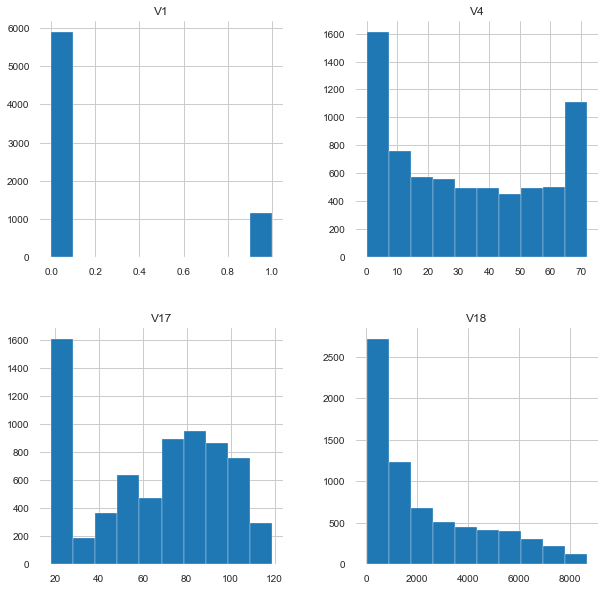

In [16]:
Tdata[Num_cols].hist(figsize = (10,10));

Data is skewed in V17 & V18 variables<br>
    <b>Lets see the binaary and multiclass variables</b><br>
Creating function to see all the object data type variables using single function

In [18]:
def cat_col_desc(data):
    col_list = data.select_dtypes(include=['object']).columns.tolist()
    for i in col_list: 
        print("Variable :", i)
        print("Count of unique values :", len(set( data[i])))
        print("Unique values : " ,set( data[i]))
        print("================================")

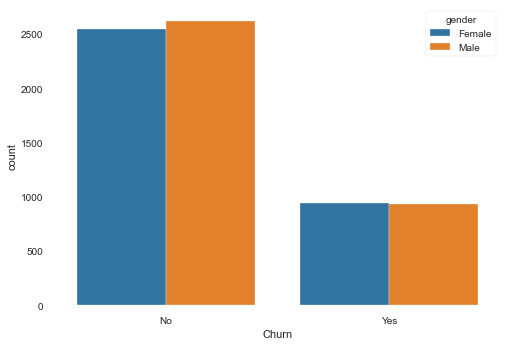

In [19]:
sns.countplot(x="Churn", hue="gender", data=Tdata)

In [20]:
Binary_class = Tdata[Cat_cols].nunique()[Tdata[Cat_cols].nunique() == 2].keys().tolist()
Multi_class =  Tdata[Cat_cols].nunique()[Tdata[Cat_cols].nunique() > 2].keys().tolist()
print(Binary_class)
print(Multi_class)

['gender', 'V2', 'V3', 'V5', 'V15', 'Churn']
['V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V16']


* Look at multi class variables distribution

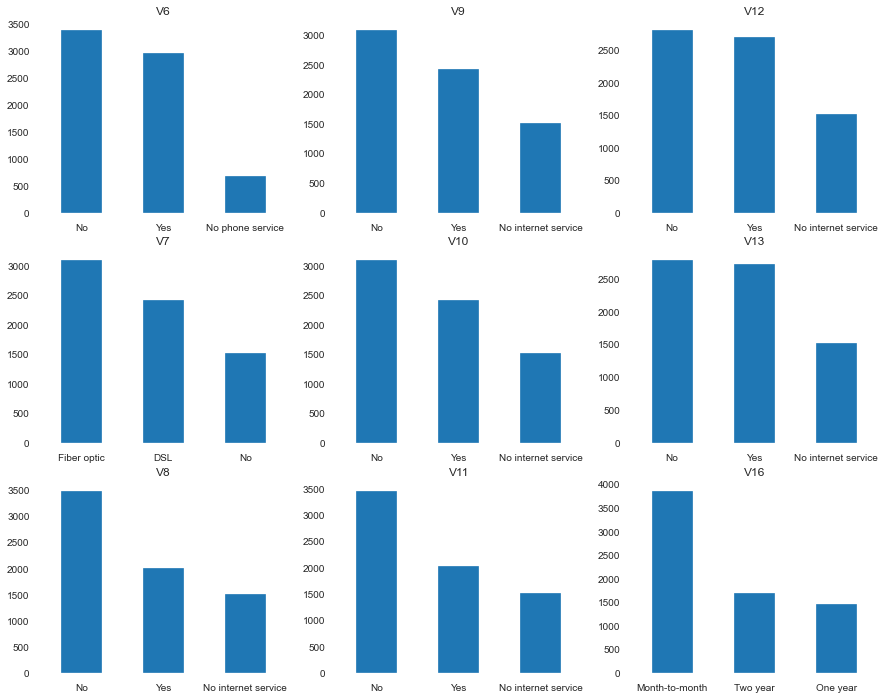

In [21]:
fig, axes = plt.subplots(nrows = 3,ncols = 3,figsize = (15,12))
for i, item in enumerate(Multi_class):
    if i < 3:
        ax = Tdata[item].value_counts().plot(kind = 'bar',ax=axes[i,0],rot = 0)
        
    elif i >=3 and i < 6:
        ax = Tdata[item].value_counts().plot(kind = 'bar',ax=axes[i-3,1],rot = 0)
        
    elif i < 9:
        ax = Tdata[item].value_counts().plot(kind = 'bar',ax=axes[i-6,2],rot = 0)
    ax.set_title(item)

Look at binary class variables distribution

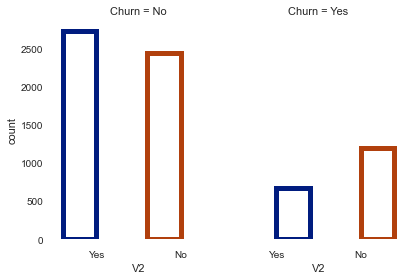

In [22]:
sns.catplot(x="V2", hue="Churn", col="Churn",data=Tdata, kind="count",height=4, aspect=.7,  facecolor=(0, 0, 0, 0),
linewidth=5,edgecolor=sns.color_palette("dark", 5))

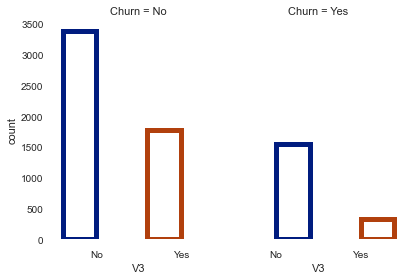

In [23]:
#Tdata.groupby('V3')['Churn'].count().plot(kind = 'barh')
sns.catplot(x="V3", hue="Churn", col="Churn",data=Tdata, kind="count",height=4, aspect=.7,  facecolor=(0, 0, 0, 0),
linewidth=5,edgecolor=sns.color_palette("dark", 5))

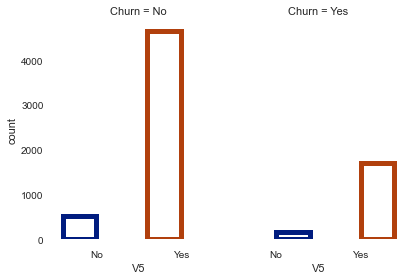

In [24]:
sns.catplot(x="V5", hue="Churn", col="Churn",data=Tdata, kind="count",height=4, aspect=.7,  facecolor=(0, 0, 0, 0),
linewidth=5,edgecolor=sns.color_palette("dark", 5))

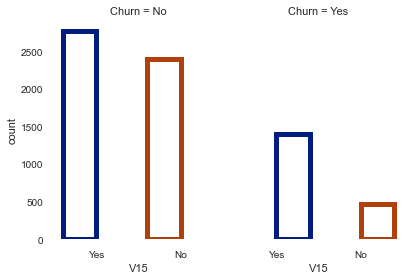

In [25]:
sns.catplot(x="V15", hue="Churn", col="Churn",data=Tdata, kind="count",height=4, aspect=.7,  facecolor=(0, 0, 0, 0),
linewidth=5,edgecolor=sns.color_palette("dark", 5))

## Tranforming the data

In [26]:
from sklearn import preprocessing
#Label encoding Binary columns
le = preprocessing.LabelEncoder()
for i in Binary_class :
    Tdata[i] = le.fit_transform(Tdata[i])

In [27]:
Tdata[Binary_class].shape

(7043, 6)

In [28]:
Tdata[Num_cols].shape

(7043, 4)

In [29]:
# Split multi class catergory columns as dummies  
Tdata_Dummy = pd.get_dummies(Tdata[Multi_class])
Tdata_Dummy.head()

,V6_No,V6_No phone service,V6_Yes,V7_DSL,V7_Fiber optic,V7_No,V8_No,V8_No internet service,V8_Yes,V9_No,...,V13_No,V13_No internet service,V13_Yes,V14_Month-to-month,V14_One year,V14_Two year,V16_Bank transfer (automatic),V16_Credit card (automatic),V16_Electronic check,V16_Mailed check
0,0,1,0,1,0,0,1,0,0,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,1,0,0,0,0,1,1,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,1,0,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0,1
3,0,1,0,1,0,0,0,0,1,1,...,1,0,0,0,1,0,1,0,0,0
4,1,0,0,0,1,0,1,0,0,1,...,1,0,0,1,0,0,0,0,1,0


In [30]:
New_df = pd.concat([Tdata[Num_cols],Tdata[Binary_class],Tdata_Dummy], axis=1)
New_df.shape

(7043, 41)

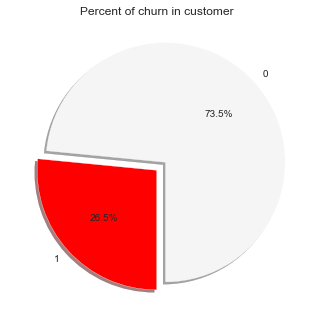

In [31]:
labels =New_df['Churn'].value_counts(sort = True).index
sizes = New_df['Churn'].value_counts(sort = True)

colors = ["whitesmoke","red"]
explode = (0.1,0)  # explode 1st slice
 
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct='%1.1f%%', shadow=True, startangle=270,)

plt.title('Percent of churn in customer')
plt.show()

## correlation
Lets check the correlation between the variables

In [32]:
#correlation
corr = New_df.corr()

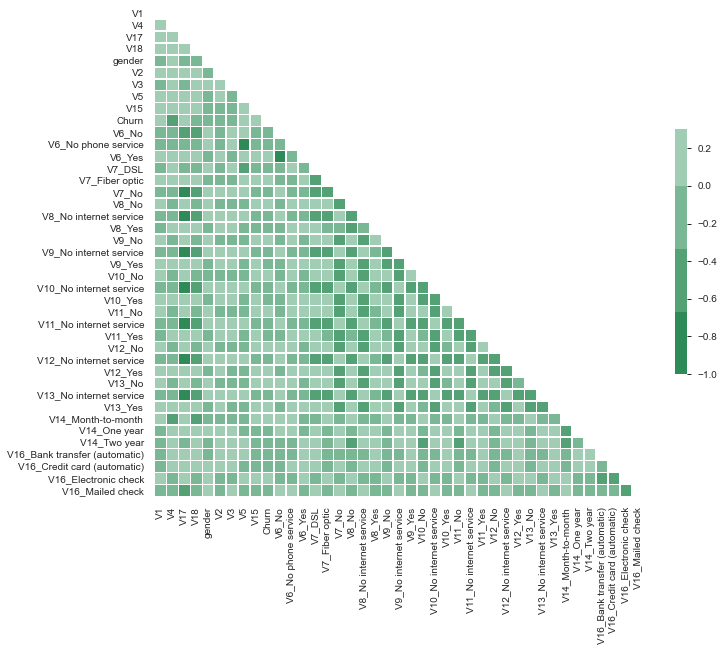

In [33]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap=sns.light_palette("seagreen", reverse=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

From the above heatmap we can see the highly correlated variables with dark green associated<br>
For example<br>
V4 variable is highly correlated with V14 Month to Month and Churn V17 is correlated with most of the variables with No internete service and NO classes<br>

Like the above examples we can interpret the variables with most correlated in the same data set

## Important variables

In [34]:
X = New_df.loc[:, New_df.columns != 'Churn']
y = New_df["Churn"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state =1)

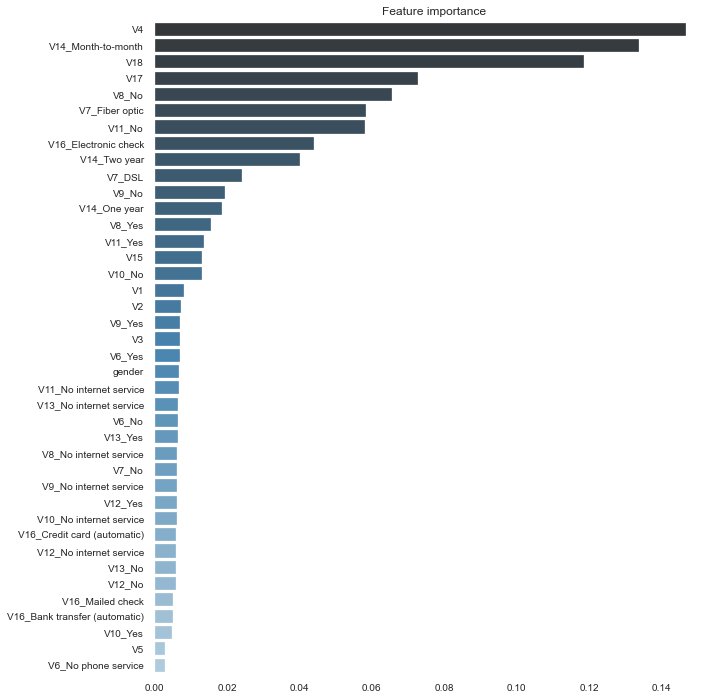

In [35]:
params = {'random_state': 0, 'n_jobs': 4, 'n_estimators': 5000, 'max_depth': 8}

# Fit RandomForest Classifier
clf = RandomForestClassifier(**params)
clf = clf.fit(X, y)
# Plot features importances
imp = pd.Series(data=clf.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')

Since V4 having the highest important variables lets look more closely

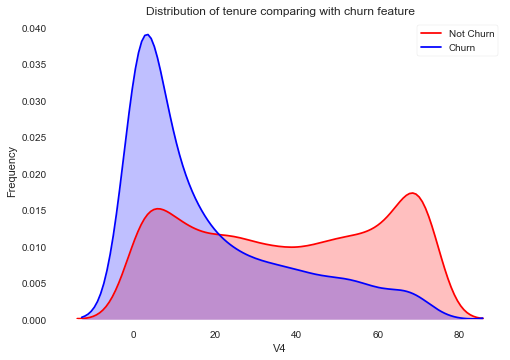

In [36]:
# V4 distibution 
g = sns.kdeplot(New_df.V4[(New_df["Churn"] == 0) ], color="Red", shade = True)
g = sns.kdeplot(New_df.V4[(New_df["Churn"] == 1) ], ax =g, color="Blue", shade= True)
g.set_xlabel("V4")
g.set_ylabel("Frequency")
plt.title('Distribution of tenure comparing with churn feature')
g = g.legend(["Not Churn","Churn"])

There is a chance that customer will churn based on V4 . Lesser the range more chance of churn

In [37]:
print(sorted(New_df["V4"].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]


* According to above important variable plot, V17 & V18 may affect to churn probability.
* And seem like customer will not churn if they have lower range

## Split Train Test

In [38]:
X = New_df.loc[:, New_df.columns != 'Churn']
y = New_df["Churn"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state =1)

In [39]:
print('The number of samples into the Train data is {}.'.format(x_train.shape[0]))
print('The number of samples into the test data is {}.'.format(x_test.shape[0]))

The number of samples into the Train data is 5634.
The number of samples into the test data is 1409.


In [40]:
logistic_model = LogisticRegression()
logistic_model.fit(x_train,y_train)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [42]:
accuracy = logistic_model.score(x_test,y_test)
print("Logistic Regression accuracy is :",accuracy*100)

Logistic Regression accuracy is : 81.26330731014905


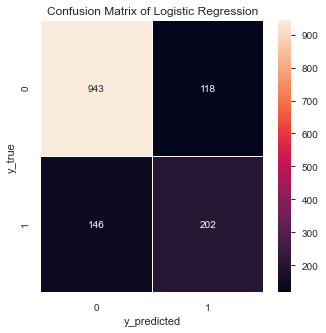

In [43]:
#for Logistic Regression
cm_lr = confusion_matrix(y_test,logistic_model.predict(x_test))

# %% confusion matrix visualization
import seaborn as sns
f, ax = plt.subplots(figsize = (5,5))
sns.heatmap(cm_lr, annot = True, linewidths = 0.5, color = "red", fmt = ".0f", ax=ax)
plt.xlabel("y_predicted")
plt.ylabel("y_true")
plt.title("Confusion Matrix of Logistic Regression")
plt.show()

## Using Grid search CV and L1 Penality for logistic regression

In [52]:
# Define Model parameters to tune
model_parameters = {
        'C': [1,10,100,1000],
        'class_weight': ['balanced', None]
    }

In [53]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
# Gridsearch the parameters to find the best parameters. Using L1 penalty
model = LogisticRegression(penalty='l1')
gscv = GridSearchCV(estimator=model, 
                    param_grid=model_parameters, 
                    cv=5, 
                    verbose=1, 
                    n_jobs=-1,
                    scoring='f1')

gscv.fit(x_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.1s finished


ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

In [54]:
print('The best parameter are -', gscv.best_params_)

The best parameter are - {'C': 1, 'class_weight': 'balanced'}


In [55]:
# Re-fit the model with the best parameters
final_mod = LogisticRegression(**gscv.best_params_)
final_mod.fit(x_train,y_train)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1, class_weight='balanced')

In [56]:
# View the model coefficients
list(zip(x_train.columns, final_mod.coef_[0]))

[('V1', 0.21719690144384432),
 ('V4', -0.05676983169772622),
 ('V17', 0.005952985723300231),
 ('V18', 0.00030687489733221364),
 ('gender', -0.038190640839542406),
 ('V2', 0.049175604961297886),
 ('V3', -0.09866874477745113),
 ('V5', -0.2603853823596743),
 ('V15', 0.35670557617276566),
 ('V6_No', -0.1921798152844355),
 ('V6_No phone service', 0.20451971909445296),
 ('V6_Yes', -0.06820556708226175),
 ('V7_DSL', -0.2635203064973345),
 ('V7_Fiber optic', 0.2801864105471458),
 ('V7_No', -0.07253176731107937),
 ('V8_No', 0.2092063738209256),
 ('V8_No internet service', -0.07253176731107937),
 ('V8_Yes', -0.1925402697764238),
 ('V9_No', 0.1083920623218944),
 ('V9_No internet service', -0.07253176731107937),
 ('V9_Yes', -0.09172595827307384),
 ('V10_No', 0.09476656235704681),
 ('V10_No internet service', -0.07253176731107937),
 ('V10_Yes', -0.07810045830440866),
 ('V11_No', 0.1854214484617374),
 ('V11_No internet service', -0.07253176731107937),
 ('V11_Yes', -0.1687553444076718),
 ('V12_No', -

In [57]:
confusion_matrix(y_test,final_mod.predict(x_test))

array([[773, 288],
       [ 59, 289]], dtype=int64)

In [58]:
from sklearn.metrics import classification_report

print(classification_report(y_test,final_mod.predict(x_test)))

              precision    recall  f1-score   support

           0       0.93      0.73      0.82      1061
           1       0.50      0.83      0.62       348

    accuracy                           0.75      1409
   macro avg       0.71      0.78      0.72      1409
weighted avg       0.82      0.75      0.77      1409



Train AUC =  0.8452032993636538
Test AUC =  0.8584546675766735


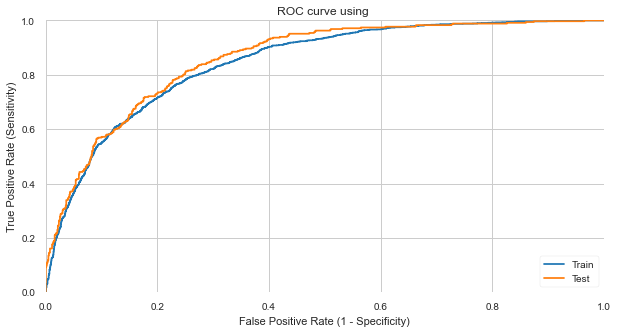

In [59]:
# Generate ROC
plt.subplots(figsize=(10, 5))
train_prob = final_mod.predict_proba(x_train)[:, 1]
test_prob = final_mod.predict_proba(x_test)[:, 1]

plot_roc_curve(y_train, train_prob,
               y_test, test_prob)